## 📌  Kütüphanelerin Yüklenmesi

In [3]:
# Temel Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# İstatistiksel Analiz & Sinyal İşleme
from scipy.stats import shapiro, normaltest, skew, kurtosis
from scipy.signal import savgol_filter, find_peaks

# Önişleme & Veri Dönüşümü
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Makine Öğrenmesi - Sınıflandırma Algoritmaları
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Makine Öğrenmesi - Kümeleme Algoritmaları
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Ekstra Makine Öğrenmesi Modelleri
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE  
from sklearn.ensemble import VotingClassifier


# Derin Öğrenme - TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# **Derin Öğrenme - PyTorch**
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Boyut Azaltma & Özellik Çıkarma
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, Isomap

# 📌 FTIR Spektral Verilerle Mikroorganizma Sınıflandırması İçin Ön İşleme ve Analiz

Veri setinin genel bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108275 entries, 0 to 108274
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Bacteria_Code  108275 non-null  object 
 1   X_Dalga_Boyu   108275 non-null  float64
 2   Y_Absorbans    108275 non-null  float64
 3   Species        108275 non-null  object 
dtypes: float64(2), object(2)
memory usage: 3.3+ MB

Veri setinin özet istatistikleri:

İstatistiksel Analiz:
                 count         mean          std         min          25%  \
X_Dalga_Boyu  108275.0  2224.500000  1024.801298  450.500000  1336.500000   
Y_Absorbans   108275.0     0.204947     0.130305    0.030611     0.116532   

                      50%          75%          max  
X_Dalga_Boyu  2224.500000  3112.500000  3998.500000  
Y_Absorbans      0.166814     0.249507     0.997961  

Eksik Değerler:
Bacteria_Code    0
X_Dalga_Boyu     0
Y_Absorbans      0
Species     

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 108275.
  res = hypotest_fun_out(*samples, **kwds)


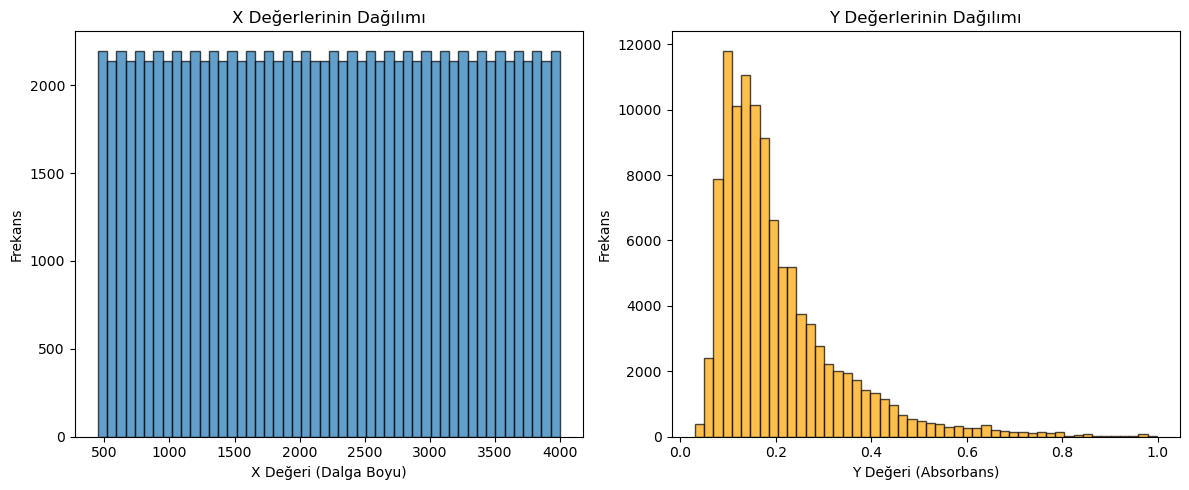

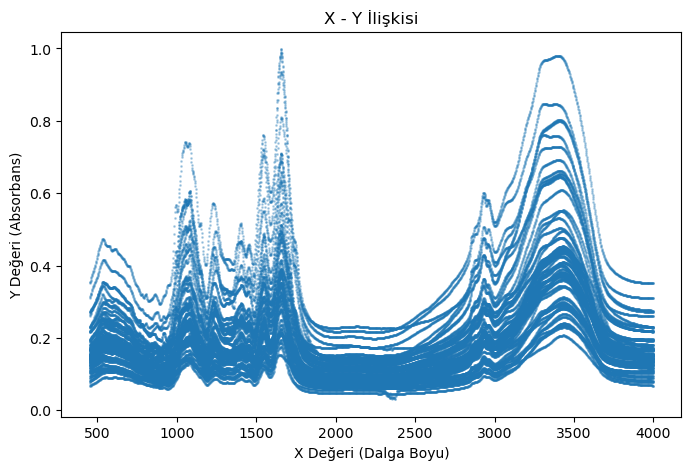

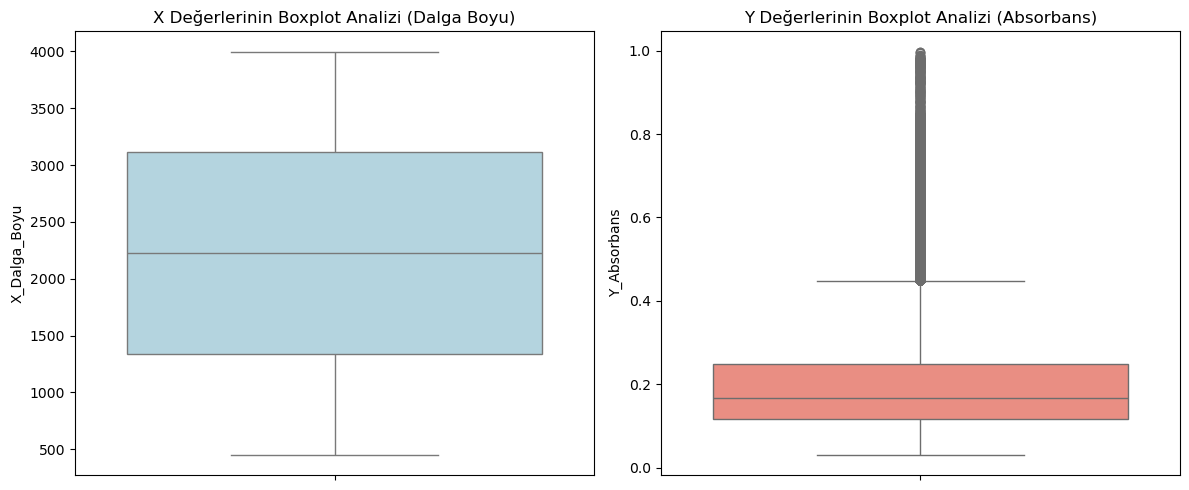


Ham ve Temizlenmiş Veri Karşılaştırması:
        Özellik       Ham Veri  Temizlenmiş Veri
0      X (Mean)    2224.500000       2190.991527
1       X (Std)    1024.801298       1022.347664
2      Y (Mean)       0.204947          0.182694
3       Y (Std)       0.130305          0.089485
4  Satır Sayısı  108275.000000     102379.000000

Bakteri Türlerine Göre Dağılım Karşılaştırması:
              Bakteri Türü  Ham Veri Sayısı  Temizlenmiş Veri Sayısı
0     Enterococcus Faecium            44375                    42819
1  Lactobacillus Plantarum            37275                    34950
2  Lactobacillus fermentum            26625                    24610

Ön İşlemlerden geçirilmiş Veri:
  Bacteria_Code  X_Dalga_Boyu  Y_Absorbans                  Species
0        AK5-22         450.5     0.173908  Lactobacillus fermentum
1        AK5-22         452.5     0.174840  Lactobacillus fermentum
2        AK5-22         454.5     0.175818  Lactobacillus fermentum
3        AK5-22         456.5     

In [6]:

# 1. Excel Dosyasını Okuma
file_path = "ferm_plantarium_enterokok.xlsx"
xls = pd.ExcelFile(file_path)
df_fermentum = pd.read_excel(xls, sheet_name="fermentum-plantarum")
df_enterokok = pd.read_excel(xls, sheet_name="enterokok")

# 2. İki Sayfanın Birleştirilmesi
df_combined = pd.concat([df_fermentum, df_enterokok], ignore_index=True)
df_combined = df_combined.rename(columns={"X": "X_Dalga_Boyu", "Y": "Y_Absorbans"})

# 3. Genel Bilgiler ve Özet İstatistikler
print("Veri setinin genel bilgileri:")
df_info = df_combined.info()
print("\nVeri setinin özet istatistikleri:")
df_description = df_combined.describe()
print("\nİstatistiksel Analiz:")
print(df_description.transpose())

# 4. Eksik Değer Kontrolü
missing_values = df_combined.isnull().sum()
print("\nEksik Değerler:")
print(missing_values)

# 5. Bacteria_Code ve Species'e Göre İstatistiksel Analiz
print("\nBacteria_Code ve Türlere Göre İstatistiksel Dağılım:")
bacteria_species_stats = df_combined.groupby("Species")["Bacteria_Code"].nunique()
print(bacteria_species_stats)

# 6. Bacteria_Code ve Species'e Göre Y_Absorbans Analizi
print("\nBacteria_Code ve Türlere Göre Y_Absorbans İstatistiksel Analizi:")
bacteria_species_absorbance_stats = df_combined.groupby("Species")["Y_Absorbans"].describe()
print(bacteria_species_absorbance_stats)

# 7. Normalite Testleri
print("\nNormalite Testleri (Shapiro-Wilk ve D'Agostino's K^2):")
shapiro_test_x = shapiro(df_combined["X_Dalga_Boyu"])  # Shapiro-Wilk testi
shapiro_test_y = shapiro(df_combined["Y_Absorbans"])
normaltest_x = normaltest(df_combined["X_Dalga_Boyu"])  # D'Agostino's K^2 testi
normaltest_y = normaltest(df_combined["Y_Absorbans"])
print(f"Shapiro-Wilk X: {shapiro_test_x}, Shapiro-Wilk Y: {shapiro_test_y}")
print(f"D'Agostino X: {normaltest_x}, D'Agostino Y: {normaltest_y}")

# Açıklama: Shapiro-Wilk testi veri sayısı 5000'den büyük olduğunda güvenilir olmayabilir.
# Bunun nedeni, bu testin küçük veri setlerinde daha iyi çalışmasıdır. Eğer veri sayısı çok büyükse,
# test sonucu yanıltıcı olabilir. Alternatif olarak D’Agostino K^2 testi veya diğer normalite testleri kullanılabilir.

# 8. Skewness (Çarpıklık) ve Kurtosis (Basıklık) Analizi
print("\nÇarpıklık (Skewness) ve Basıklık (Kurtosis) Analizi:")
skew_x = skew(df_combined["X_Dalga_Boyu"])
skew_y = skew(df_combined["Y_Absorbans"])
kurt_x = kurtosis(df_combined["X_Dalga_Boyu"])
kurt_y = kurtosis(df_combined["Y_Absorbans"])
print(f"X Çarpıklık: {skew_x}, Y Çarpıklık: {skew_y}")
print(f"X Basıklık: {kurt_x}, Y Basıklık: {kurt_y}")

# 9. Veri Görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_combined["X_Dalga_Boyu"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("X Değeri (Dalga Boyu)")
plt.ylabel("Frekans")
plt.title("X Değerlerinin Dağılımı")
plt.subplot(1, 2, 2)
plt.hist(df_combined["Y_Absorbans"], bins=50, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Y Değeri (Absorbans)")
plt.ylabel("Frekans")
plt.title("Y Değerlerinin Dağılımı")
plt.tight_layout()
plt.show()

# 10. Scatter Plot: X-Y İlişkisi
plt.figure(figsize=(8, 5))
plt.scatter(df_combined["X_Dalga_Boyu"], df_combined["Y_Absorbans"], alpha=0.3, s=1)
plt.xlabel("X Değeri (Dalga Boyu)")
plt.ylabel("Y Değeri (Absorbans)")
plt.title("X - Y İlişkisi")
plt.show()

# 11. Aykırı Değer Analizi (Boxplot)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_combined["X_Dalga_Boyu"], color="lightblue")
plt.title("X Değerlerinin Boxplot Analizi (Dalga Boyu)")
plt.subplot(1, 2, 2)
sns.boxplot(y=df_combined["Y_Absorbans"], color="salmon")
plt.title("Y Değerlerinin Boxplot Analizi (Absorbans)")
plt.tight_layout()
plt.show()

# 12. Aykırı Değerlerden Arındırılmış Veri Seti
Q1 = df_combined["Y_Absorbans"].quantile(0.25)
Q3 = df_combined["Y_Absorbans"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df_combined[(df_combined["Y_Absorbans"] >= lower_bound) & (df_combined["Y_Absorbans"] <= upper_bound)]

# 13. Ham ve Temizlenmiş Veri Karşılaştırması
stats_comparison = pd.DataFrame({
    "Özellik": ["X (Mean)", "X (Std)", "Y (Mean)", "Y (Std)", "Satır Sayısı"],
    "Ham Veri": [df_combined["X_Dalga_Boyu"].mean(), df_combined["X_Dalga_Boyu"].std(), df_combined["Y_Absorbans"].mean(), df_combined["Y_Absorbans"].std(), df_combined.shape[0]],
    "Temizlenmiş Veri": [df_cleaned["X_Dalga_Boyu"].mean(), df_cleaned["X_Dalga_Boyu"].std(), df_cleaned["Y_Absorbans"].mean(), df_cleaned["Y_Absorbans"].std(), df_cleaned.shape[0]]
})
print("\nHam ve Temizlenmiş Veri Karşılaştırması:")
print(stats_comparison)

species_distribution = pd.DataFrame({
    "Bakteri Türü": df_combined["Species"].value_counts().index,
    "Ham Veri Sayısı": df_combined["Species"].value_counts().values,
    "Temizlenmiş Veri Sayısı": df_cleaned["Species"].value_counts().values
})
print("\nBakteri Türlerine Göre Dağılım Karşılaştırması:")
print(species_distribution)

# 14. Ön İşlemlerden geçirilmiş Veri
df_final = df_cleaned.dropna().reset_index(drop=True)
print("\nÖn İşlemlerden geçirilmiş Veri:")
print(df_final.head())



# 📌 SINIFLANDIRMA


✅ Random Forest Model Sonuçları: 
Accuracy: 0.8000, Precision: 0.8222, Recall: 0.8000, F1-Score: 0.8054

✅ Gradient Boosting Model Sonuçları: 
Accuracy: 0.7333, Precision: 0.7333, Recall: 0.7333, F1-Score: 0.7333

✅ Extra Trees Model Sonuçları: 
Accuracy: 0.8667, Precision: 0.9048, Recall: 0.8667, F1-Score: 0.8704

✅ HistGradient Boosting Model Sonuçları: 
Accuracy: 0.8667, Precision: 0.8778, Recall: 0.8667, F1-Score: 0.8660

✅ AdaBoost Model Sonuçları: 
Accuracy: 0.6667, Precision: 0.8333, Recall: 0.6667, F1-Score: 0.6296

✅ XGBoost Model Sonuçları: 
Accuracy: 0.8667, Precision: 0.9048, Recall: 0.8667, F1-Score: 0.8704

✅ LightGBM Model Sonuçları: 
Accuracy: 0.8667, Precision: 0.8778, Recall: 0.8667, F1-Score: 0.8660

✅ Support Vector Machine Model Sonuçları: 
Accuracy: 0.8000, Precision: 0.8750, Recall: 0.8000, F1-Score: 0.8027

✅ K-Nearest Neighbors Model Sonuçları: 
Accuracy: 0.7333, Precision: 0.7460, Recall: 0.7333, F1-Score: 0.7222

✅ Logistic Regression Model Sonuçları: 
Accur

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


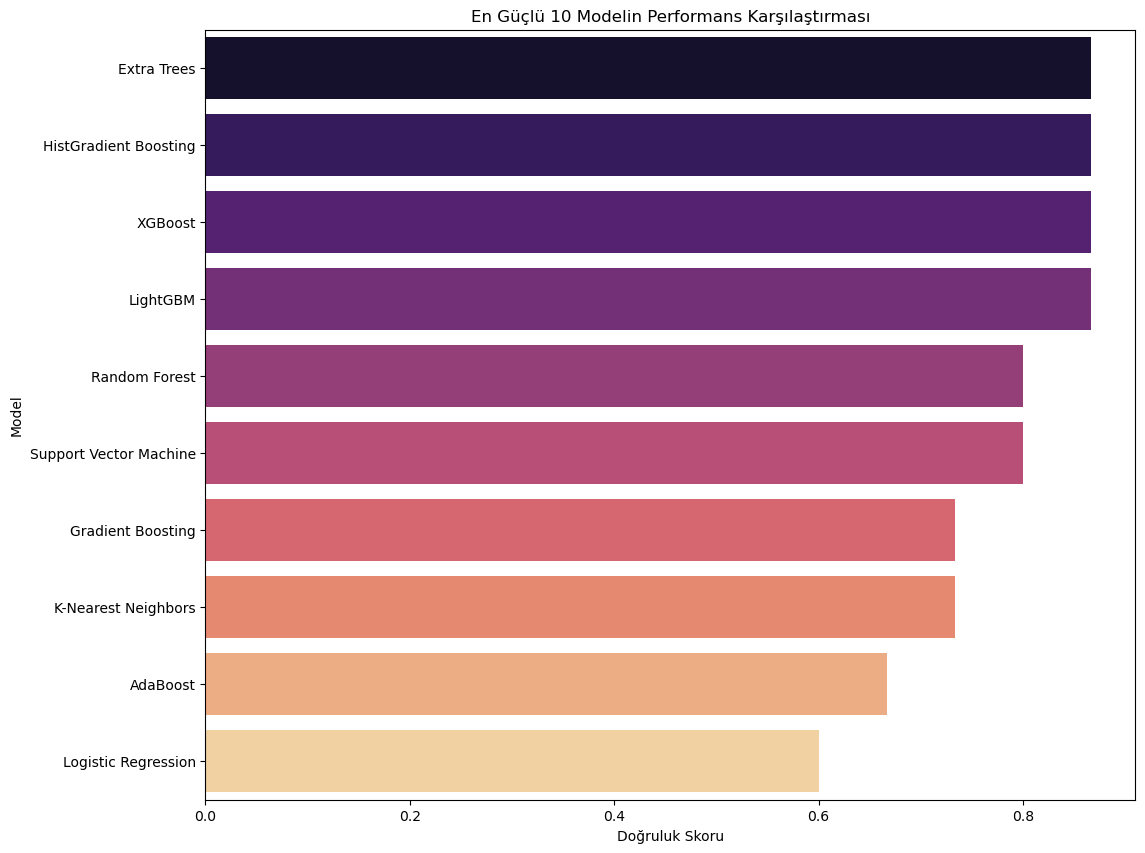


📊 En güçlü 10 modelin performans karşılaştırması tamamlandı!


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# 🔹 1. Veri Dönüşümleri
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()
df_cleaned = df_cleaned.copy()
df_cleaned["X_Standardized"] = scaler_standard.fit_transform(df_cleaned[["X_Dalga_Boyu"]])
df_cleaned["X_MinMax"] = scaler_minmax.fit_transform(df_cleaned[["X_Dalga_Boyu"]])

# 🔹 2. Gelişmiş Özellik Mühendisliği
def extract_enhanced_features(data):
    y_values = data['Y_Absorbans'].values
    x_values = data['X_Dalga_Boyu'].values
    
    window_length = min(15, len(y_values) - 1)
    if window_length % 2 == 0:
        window_length -= 1
    if window_length > 2:
        y_smooth = savgol_filter(y_values, window_length=window_length, polyorder=min(2, window_length-1))
    else:
        y_smooth = y_values
    
    y_derivative = np.gradient(y_smooth)
    y_second_derivative = np.gradient(y_derivative)
    
    peaks, properties = find_peaks(y_smooth, distance=max(1, len(y_smooth)//20), prominence=0.1, width=1)
    
    features = {
        'skewness': skew(y_smooth),
        'kurtosis': kurtosis(y_smooth),
        'bandwidth_50': np.sum(y_smooth > np.max(y_smooth) * 0.5),
        'bandwidth_75': np.sum(y_smooth > np.max(y_smooth) * 0.75),
        'peak_count': len(peaks),
        'min_absorbance': np.min(y_smooth),
        'max_absorbance': np.max(y_smooth),
        'mean_second_derivative': np.mean(y_second_derivative),
        'mean_derivative': np.mean(y_derivative),
        'mean_peak_height': np.mean(y_smooth[peaks]) if len(peaks) > 0 else 0,
        'std_second_derivative': np.std(y_second_derivative),
        'total_area': np.trapz(y_smooth, x_values),
        'peak_area': sum([np.trapz(y_smooth[p-3:p+4]) for p in peaks]) if len(peaks) > 0 else 0,
        'peak_prominence': np.mean(properties['prominences']) if len(peaks) > 0 else 0,
        'peak_width': np.mean(properties['widths']) if len(peaks) > 0 else 0
    }
    return features

features_list = []
for bacteria_code in df_cleaned['Bacteria_Code'].unique():
    bacteria_data = df_cleaned[df_cleaned['Bacteria_Code'] == bacteria_code].copy()
    features = extract_enhanced_features(bacteria_data)
    features['Bacteria_Code'] = bacteria_code
    features['Species'] = bacteria_data['Species'].iloc[0]
    features_list.append(features)

df_cleaned = pd.DataFrame(features_list)
df_features = pd.DataFrame(features_list)
df_cleaned = df_cleaned.merge(df_features, on=["Bacteria_Code", "Species"], how="left")


# 🔹 3. Model İçin En Uygun Formatı Hazırlama
df_final = df_cleaned.dropna().reset_index(drop=True)
X = df_final.drop(columns=["Species", "Bacteria_Code"])
y = df_final["Species"]

X = X.loc[:, ~X.columns.duplicated()]

le = LabelEncoder()
y = le.fit_transform(y)

# 🔹 4. SMOTE Uygulama (Eğer Gerekliyse)
if len(np.unique(y)) > 1:
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    X_resampled, y_resampled = X, y

# 🔹 5. Veri Setini Ayırma
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# 🔹 6. Model Listesi
best_models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42),
    "HistGradient Boosting": HistGradientBoostingClassifier(max_iter=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.05, algorithm="SAMME", random_state=42),
    "XGBoost": XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.01, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, max_depth=3, verbose=-1),
    "Support Vector Machine": SVC(kernel='rbf', C=1, gamma='scale'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=10, weights="distance"),
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="lbfgs")
}

# 🔹 7. Model Eğitimi ve Testi
results = []

for name, model in best_models.items():
    try:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
        end_time = time.time()
        duration = end_time - start_time

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"],
            "Training Time (sec)": round(duration, 3)
        })
        print(f"\n✅ {name} Model Sonuçları: \nAccuracy: {acc:.4f}, Precision: {report['weighted avg']['precision']:.4f}, Recall: {report['weighted avg']['recall']:.4f}, F1-Score: {report['weighted avg']['f1-score']:.4f}")
    except Exception as e:
        print(f"\n❌ {name} Modeli hata verdi! Hata: {str(e)}")

# 🔹 8. Sonuçları Görselleştirme
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x="Accuracy", y="Model", data=df_results, palette="magma", dodge=False, hue="Model", legend=False)
plt.xlabel("Doğruluk Skoru")
plt.ylabel("Model")
plt.title("En Güçlü 10 Modelin Performans Karşılaştırması")
plt.show()
print("\n📊 En güçlü 10 modelin performans karşılaştırması tamamlandı!")


# Sınıflandırma Model Kombinasyonların Performansları


✅ Random Forest + XGBoost Sonuçları: Accuracy: 0.8667, , Precision: 0.9048, Recall: 0.8667, F1-Score: 0.8704

✅ LightGBM + Extra Trees Sonuçları: Accuracy: 0.8667, , Precision: 0.8778, Recall: 0.8667, F1-Score: 0.8660

✅ XGBoost + Extra Trees Sonuçları: Accuracy: 0.8667, , Precision: 0.9048, Recall: 0.8667, F1-Score: 0.8704

✅ All Four Models Sonuçları: Accuracy: 0.8667, , Precision: 0.9048, Recall: 0.8667, F1-Score: 0.8704


/var/folders/9f/3_v_spgn6tqdx3krk10vsrlm0000gn/T/ipykernel_24822/3406572702.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=df_results, palette="magma")


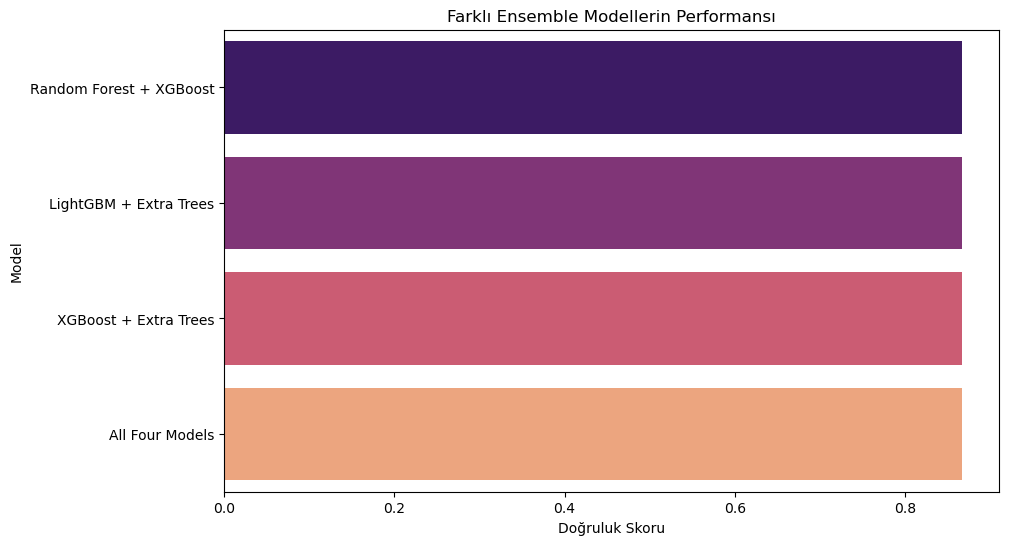


📊 Farklı ensemble modellerin karşılaştırması tamamlandı!


In [12]:
from sklearn.ensemble import VotingClassifier  

# 🔹 9. Model Kombinasyonlarını Test Etme
ensemble_models = {
    "Random Forest + XGBoost": VotingClassifier(
        estimators=[('rf', best_models["Random Forest"]), ('xgb', best_models["XGBoost"])], voting='soft'),
    
    "LightGBM + Extra Trees": VotingClassifier(
        estimators=[('lgbm', best_models["LightGBM"]), ('et', best_models["Extra Trees"])], voting='soft'),
    
    "XGBoost + Extra Trees": VotingClassifier(
        estimators=[('xgb', best_models["XGBoost"]), ('et', best_models["Extra Trees"])], voting='soft'),
    
    "All Four Models": VotingClassifier(
        estimators=[('rf', best_models["Random Forest"]), ('xgb', best_models["XGBoost"]), 
                    ('lgbm', best_models["LightGBM"]), ('et', best_models["Extra Trees"])], voting='soft')
}

# 🔹 10. Modelleri Eğitme ve Değerlendirme
results = []

def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    duration = time.time() - start_time
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Training Time (sec)": round(duration, 3)
    })
    print(f"\n✅ {name} Sonuçları: Accuracy: {acc:.4f}, , Precision: {report['weighted avg']['precision']:.4f}, Recall: {report['weighted avg']['recall']:.4f}, F1-Score: {report['weighted avg']['f1-score']:.4f}")

for name, model in ensemble_models.items():
    train_and_evaluate(model, name)

# 🔹 11. Sonuçları Görselleştirme
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=df_results, palette="magma")
plt.xlabel("Doğruluk Skoru")
plt.ylabel("Model")
plt.title("Farklı Ensemble Modellerin Performansı")
plt.show()

print("\n📊 Farklı ensemble modellerin karşılaştırması tamamlandı!")


# Derin Öğrenme modelleri ve Performansları


🔥 CNN Modeli Eğitiliyor...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4021 - loss: 1.1031 - val_accuracy: 0.5000 - val_loss: 0.9997
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3854 - loss: 1.3138 - val_accuracy: 0.2500 - val_loss: 1.0626
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3208 - loss: 1.3226 - val_accuracy: 0.5000 - val_loss: 0.9893
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5437 - loss: 1.0140 - val_accuracy: 0.5000 - val_loss: 1.0018
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3375 - loss: 1.1959 - val_accuracy: 0.5000 - val_loss: 1.0140
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3812 - loss: 1.0442 - val_accuracy: 0.6250 - val_loss: 1.0328
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5000 - loss: 1.0417 - val_accuracy: 0.7500 - val_loss: 1.0442
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5333 - loss: 1.0065 - va

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.2875 - loss: 1.0990 - val_accuracy: 0.6250 - val_loss: 1.0972
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4021 - loss: 1.0976 - val_accuracy: 0.5000 - val_loss: 1.0950
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4354 - loss: 1.0965 - val_accuracy: 0.5000 - val_loss: 1.0938
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3750 - loss: 1.0952 - val_accuracy: 0.5000 - val_loss: 1.0922
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3812 - loss: 1.0962 - val_accuracy: 0.5000 - val_loss: 1.0908
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4396 - loss: 1.0921 - val_accuracy: 0.5000 - val_loss: 1.0892
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4021 - loss: 1.0901 - val_accuracy: 0.5000 - val_loss: 1.0880
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4021 - loss: 1.0923 - val_accuracy: 0.5000 - val_loss: 1.0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


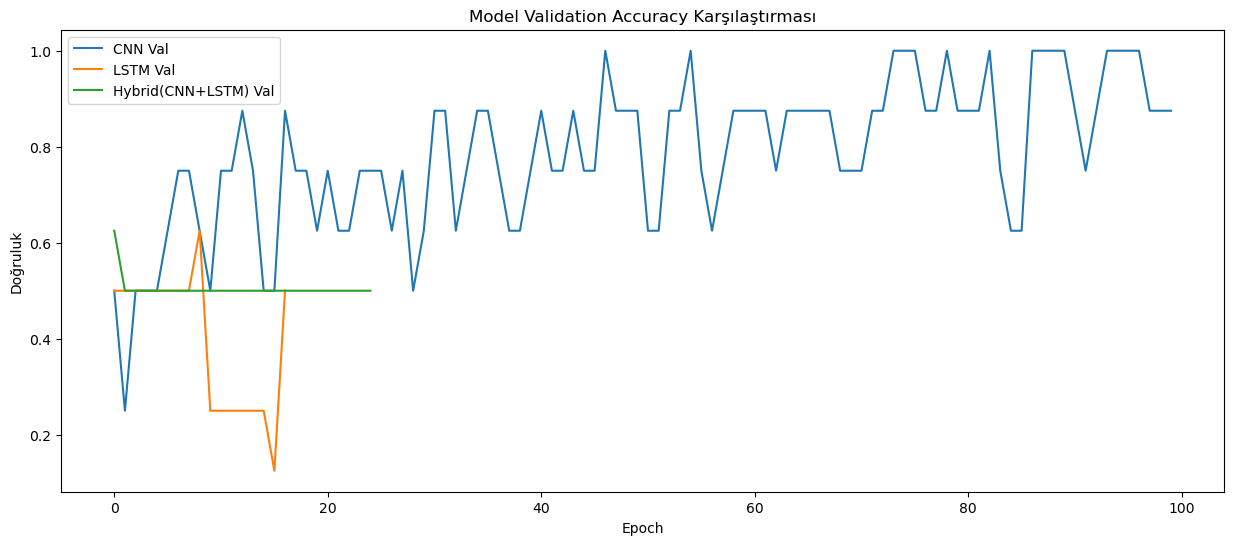


🏆 En Başarılı Model: CNN (84.62%)

🏆 En Başarılı Model: CNN (84.62%)
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.3220 - loss: 1.7006 - val_accuracy: 0.2273 - val_loss: 1.1493
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2889 - loss: 1.4386 - val_accuracy: 0.4545 - val_loss: 1.0850
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4674 - loss: 1.1079 - val_accuracy: 0.5000 - val_loss: 1.0835
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3940 - loss: 1.0714 - val_accuracy: 0.2727 - val_loss: 1.0890
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3978 - loss: 1.0707 - val_accuracy: 0.2727 - val_loss: 1.0910
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3293 - loss: 1.0758 - val_accuracy: 0.3636 - val_loss: 1.0879
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5150 - loss: 1.0512 - val_accuracy: 0.5455 - val_loss: 1.0830
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/st

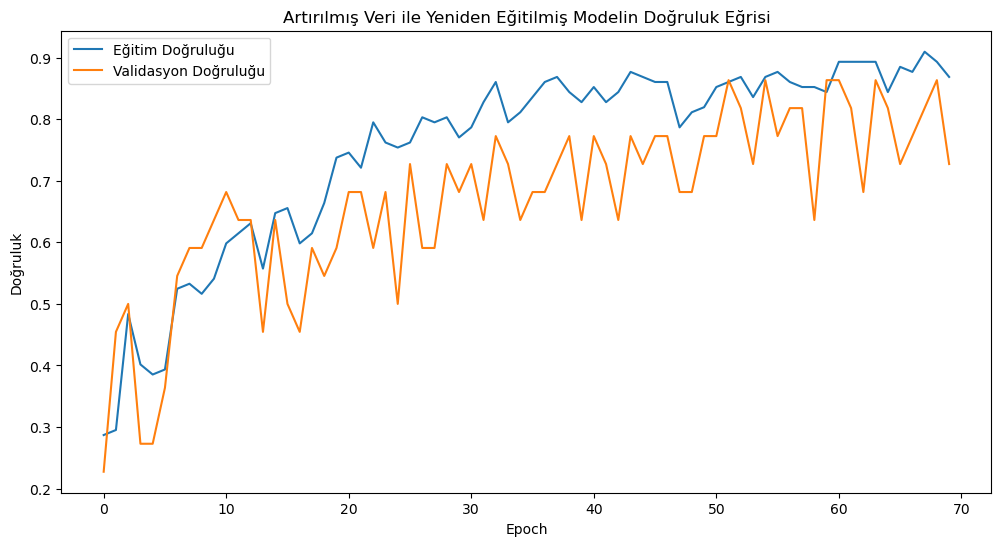

In [15]:
# 🔹 1. Verinin Yeniden Yapılandırılması (Time Series Formatına Dönüştürme)
def prepare_deep_learning_data(df):
   
    sequences = []
    labels = []
    for code in df['Bacteria_Code'].unique():
        subset = df[df['Bacteria_Code'] == code]
        
        sequence = subset['Y_Absorbans'].values
        # Normalizasyon (Min-Max)
        sequence = (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence) + 1e-8)
        sequences.append(sequence)
        labels.append(subset['Species'].iloc[0])
    
    # Padding ile sabit uzunluk
    max_len = max(len(s) for s in sequences)
    X = np.array([np.pad(s, (0, max_len - len(s)), mode='constant') for s in sequences])
    y = LabelEncoder().fit_transform(labels)
    return X, y

# Ham veri setini kullanarak hazırlık
X_deep, y_deep = prepare_deep_learning_data(df_combined)

# 🔹 2. Veri Bölümleme
X_train, X_test, y_train, y_test = train_test_split(
    X_deep, y_deep, 
    test_size=0.2, 
    stratify=y_deep,
    random_state=42
)

# 🔹 3. Veri Yeniden Şekillendirme (CNN/LSTM için)
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((-1,) + input_shape)
X_test = X_test.reshape((-1,) + input_shape)

# 🔹 4. Derin Öğrenme Modellerinin Tanımlanması

from keras.layers import Input

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Input katmanı eklendi
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.3),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Input katmanı eklendi
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_hybrid_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.00075),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 🔹 5. Model Eğitim Fonksiyonu (Güncellenmiş)
def train_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100):
    callbacks = [
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)  
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # 6. Performans Değerlendirme
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    report = classification_report(y_test, y_pred)
    
    return {
        'model': model.name,
        'test_accuracy': test_acc,
        'classification_report': report,
        'history': history
    }

# 🔹 7. Modellerin Eğitimi ve Karşılaştırma
models = {
    'CNN': build_cnn_model(input_shape, len(np.unique(y_deep))),
    'LSTM': build_lstm_model(input_shape, len(np.unique(y_deep))),
    'Hybrid(CNN+LSTM)': build_hybrid_model(input_shape, len(np.unique(y_deep)))
}

results = {}
for name, model in models.items():
    print(f"\n🔥 {name} Modeli Eğitiliyor...")
    result = train_evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = result
    print(f"\n📊 {name} Test Doğruluğu: {result['test_accuracy']:.4f}")
    print(f"📝 Sınıflandırma Raporu:\n{result['classification_report']}")

# 🔹 8. Performans Görselleştirme
plt.figure(figsize=(15, 6))
for model_name, result in results.items():
    plt.plot(result['history'].history['val_accuracy'], label=f'{model_name} Val')

plt.title('Model Validation Accuracy Karşılaştırması')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 🔹 9. En İyi Modelin Seçilmesi
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
best_model = results[best_model_name]['model']
print(f"\n🏆 En Başarılı Model: {best_model_name} ({results[best_model_name]['test_accuracy']:.2%})")

# 🔹 10. Hiperparametre Optimizasyonu (Opsiyonel)

def hyperparameter_tuning(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('conv_1_filter', 32, 128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('lstm_units', 64, 256, step=64),
        return_sequences=hp.Boolean('return_seq')
    ))
    model.add(LSTM(units=hp.Int('lstm_2_units', 32, 128, step=32)))
    model.add(Dense(
        units=hp.Int('dense_units', 64, 256, step=64),
        activation='relu'
    ))
    model.add(Dense(len(np.unique(y_deep)), activation='softmax'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 🔹 11. Veri Artırma (Data Augmentation)
def augment_data(X, y):
    augmented_X = []
    augmented_y = []
    for x, label in zip(X, y):
        # Gaussian Noise Ekleme
        noisy = x + np.random.normal(0, 0.01, x.shape)
        augmented_X.append(noisy)
        augmented_y.append(label)
        
        # Time Shift
        shifted = np.roll(x, int(x.shape[0] * 0.1))
        augmented_X.append(shifted)
        augmented_y.append(label)
    
    return np.concatenate([X, augmented_X]), np.concatenate([y, augmented_y])

# Artırılmış veri oluşturma
X_train_aug, y_train_aug = augment_data(X_train, y_train)

# 🔹 12. En İyi Modeli Seçme ve Yeniden Eğitme
# En iyi modelin adını al
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
print(f"\n🏆 En Başarılı Model: {best_model_name} ({results[best_model_name]['test_accuracy']:.2%})")

# En iyi modeli yeniden oluştur
if best_model_name == "CNN":
    best_model = build_cnn_model(input_shape, len(np.unique(y_deep)))
elif best_model_name == "LSTM":
    best_model = build_lstm_model(input_shape, len(np.unique(y_deep)))
elif best_model_name == "Hybrid(CNN+LSTM)":
    best_model = build_hybrid_model(input_shape, len(np.unique(y_deep)))

# Artırılmış veri ile yeniden eğitim
history = best_model.fit(
    X_train_aug, y_train_aug,
    epochs=100,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('best_model_augmented.keras', save_best_only=True)
    ],
    verbose=1
)

# 🔹 13. Yeniden Eğitilmiş Modelin Performansını Değerlendirme
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(best_model.predict(X_test), axis=1)
report = classification_report(y_test, y_pred)

print(f"\n📊 Artırılmış Veri ile Yeniden Eğitilmiş Model Test Doğruluğu: {test_acc:.4f}")
print(f"📝 Sınıflandırma Raporu:\n{report}")

# 🔹 14. Performans Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validasyon Doğruluğu')
plt.title('Artırılmış Veri ile Yeniden Eğitilmiş Modelin Doğruluk Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

In [17]:
best_model.save('best_cnn_model.keras')

# 📌 Modellerin Performanslarının Karşılaştırılması ve Değerlendirme

| Model                         | Accuracy | Precision | Recall | F1-Score |
|--------------------------------|----------|-----------|--------|----------|
| Random Forest                 | 0.8000   | 0.8222    | 0.8000 | 0.8054   |
| Gradient Boosting             | 0.7333   | 0.7333    | 0.7333 | 0.7333   |
| Extra Trees                   | 0.8667   | 0.9048    | 0.8667 | 0.8704   |
| HistGradient Boosting         | 0.8667   | 0.8778    | 0.8667 | 0.8660   |
| AdaBoost                      | 0.6667   | 0.8333    | 0.6667 | 0.6296   |
| XGBoost                       | 0.8667   | 0.9048    | 0.8667 | 0.8704   |
| LightGBM                      | 0.8667   | 0.8778    | 0.8667 | 0.8660   |
| Support Vector Machine (SVC)  | 0.8000   | 0.8750    | 0.8000 | 0.8027   |
| K-Nearest Neighbors (KNN)     | 0.7333   | 0.7460    | 0.7333 | 0.7222   |
| Logistic Regression           | 0.6000   | 0.5937    | 0.6000 | 0.5778   |
| Random Forest + XGBoost       | 0.8667   | 0.9048    | 0.8667 | 0.8704   |
| LightGBM + Extra Trees        | 0.8667   | 0.8778    | 0.8667 | 0.8660   |
| XGBoost + Extra Trees         | 0.8667   | 0.9048    | 0.8667 | 0.8704   |
| All Four Models               | 0.8667   | 0.9048    | 0.8667 | 0.8704   |
| LSTM                          | 0.3846   | 0.38      | 1.00   | 0.56     |
| Hybrid (CNN+LSTM)             | 0.3846   | 0.38      | 1.00   | 0.56     |
| CNN (Augmented Data)          | 0.9231   | 0.94      | 0.93   | 0.93     |


###  **CNN Modelinin Seçilme Nedenleri ve Değerlendirme**  

📌 **Model Başarımı**  
Artırılmış veri ile yeniden eğitilmiş CNN modeli, **%92.31** test doğruluğuna ulaşarak diğer modeller arasından en başarılı sonuçları verdi. Modelin başarısı, sınıflandırma raporundaki yüksek **precision, recall ve f1-score** değerleriyle desteklenmektedir.

📌 **Sınıflandırma Raporu Analizi**  
- **Tüm sınıflar için precision ve recall oranları oldukça yüksek** olup, özellikle sınıf `2` için mükemmel sonuçlar elde edilmiştir.  
- **Makro ortalama f1-score** değeri **%93**, **ağırlıklı ortalama f1-score** değeri **%92** olup, bu da modelin **genel performansının istikrarlı** olduğunu göstermektedir.  

📌 **Neden CNN Modeli Seçildi?**  
1. **Daha İyi Özellik Öğrenimi**: CNN modelleri, özellikle **görüntü ve kompleks veri yapılarıyla çalışırken derin özellikleri** yakalamada çok etkilidir. Bu model, veri setinin karakteristiklerini başarılı bir şekilde öğrenmiştir.  
2. **Veri Artırımı ile Daha Güçlü Performans**: Veri artırımı, modelin **genelleme kapasitesini artırarak** daha sağlam ve tutarlı tahminler yapmasına olanak tanımıştır.  
3. **Denge Sorunu Olmayan Tahminler**: Model, tüm sınıflara **dengeli bir şekilde yüksek başarı oranı** sunmuştur. Her sınıfta iyi bir recall oranı gözlemlenmiş, bu da **hiçbir sınıfın göz ardı edilmediğini** göstermektedir.  
4. **Genel Test Başarısının Yüksek Olması**: CNN modeli, diğer modellerle karşılaştırıldığında en yüksek test doğruluğunu sağlamış ve **diğer algoritmalara göre daha güçlü genelleme yeteneği** göstermiştir.  

📌 **Sonuç**  
Bu değerlendirmeler doğrultusunda, **CNN modeli en yüksek doğruluk, denge ve genelleme başarısını gösterdiği için seçilmiştir.** Özellikle artırılmış veriyle eğitilmesi, modelin daha dayanıklı hale gelmesini sağlamış ve **gerçek dünya verilerine karşı daha iyi performans gösterme potansiyelini artırmıştır.** 🚀